<a href="https://colab.research.google.com/github/somoon0422/Paper/blob/main/alphapose_xmlfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I modified the Pillow installation part of the AlphaPose Colab example program.**

**This is not thoth000's original program.**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install pyyaml==5.2
! pip install scipy
! pip install numpy
! pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

import torch
print(torch.__version__)
import yaml, scipy, os
print(yaml.__version__)
print(scipy.__version__)

In [ ]:
!rm -rf /content/AlphaPose
os.chdir('/content/')
!git clone https://github.com/MVIG-SJTU/AlphaPose.git

In [ ]:
!python -m pip install cython
!sudo apt-get install libyaml-dev

In [ ]:

os.chdir('/content/AlphaPose')
print(os.getcwd())
! python setup.py build develop

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

! mkdir /content/AlphaPose/detector/yolo/data
file_id = '1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/detector/yolo/data/yolov3-spp.weights')

! mkdir /content/AlphaPose/detector/tracker/data
file_id = '1nlnuYfGNuHWZztQHXwVZSL_FvfE551pA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/detector/tracker/data/JDE-1088x608-uncertainty')

file_id = '1kQhnMRURFiy7NsdS8EFL-8vtqEXOgECn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/pretrained_models/fast_res50_256x192.pth')

!wget -P ./detector/yolox/data/ https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.0/yolox_x.pth



In [ ]:
import os
os.chdir('/content/AlphaPose')
! ls
! python3 scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --indir examples/demo/ --save_img
# result json and rendered images are saved here:
! ls examples/res/
! ls examples/res/vis

In [ ]:
!pip install ultralytics

In [13]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from ultralytics import YOLO
from alphapose.utils.config import update_config
from alphapose.models import builder
from alphapose.utils.transforms import get_func_heatmap_to_coord
import xml.etree.ElementTree as ET

# 1. XML 파일에서 프레임 레이블 추출
def parse_xml_for_time_labels(xml_file, fps):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # 액션 레이블을 저장할 딕셔너리 초기화
    frame_labels = {}

    # XML 파일에서 시작 시간과 액션 정보 추출
    for event in root.findall('.//event'):
        action_name = event.find('eventname').text.strip() if event.find('eventname') is not None else None
        start_time = event.find('starttime').text.strip() if event.find('starttime') is not None else None
        duration_time = event.find('duration').text.strip() if event.find('duration') is not None else None

        if action_name and start_time and duration_time:
            try:
                # 시작 시간과 지속 시간을 초 단위로 변환
                start_parts = list(map(float, start_time.split(":")))
                start_seconds = start_parts[0] * 3600 + start_parts[1] * 60 + start_parts[2]

                duration_parts = list(map(float, duration_time.split(":")))
                duration_seconds = duration_parts[0] * 3600 + duration_parts[1] * 60 + duration_parts[2]

                # 액션이 발생하는 프레임 범위 계산
                start_frame = int(start_seconds * fps)
                end_frame = int((start_seconds + duration_seconds) * fps)

                # 각 프레임에 대해 액션 레이블 할당
                for frame in range(start_frame, end_frame + 1):
                    if frame not in frame_labels:
                        frame_labels[frame] = []
                    frame_labels[frame].append(action_name)
            except ValueError as e:
                print(f"Error parsing time for action '{action_name}': {e}")

    return frame_labels

# 2. 동영상에서 프레임 추출 및 레이블 할당
def extract_frames_with_labels(video_path, output_dir, fps, frame_labels):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)

    if video_fps == 0:
        print(f"Warning: Unable to read FPS from video {video_path}. Setting FPS to default value 30.")
        video_fps = 30

    if fps > video_fps:
        print(f"Warning: Specified FPS ({fps}) is higher than video FPS ({video_fps}) for {video_path}. Adjusting FPS to video FPS.")
        fps = video_fps

    if fps == 0:
        print(f"Error: FPS for frame extraction is set to zero. Skipping this file {video_path}.")
        cap.release()
        return []

    interval = int(video_fps / fps)

    if interval <= 0:
        print(f"Error: Interval for frame extraction is zero or negative for video {video_path}. Skipping this file.")
        cap.release()
        return []

    frame_count = 0
    extracted_count = 0
    frame_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            frame_filename = os.path.join(output_dir, f"frame_{extracted_count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)

            # 레이블 할당
            frame_label = frame_labels.get(frame_count, ['neutral'])
            frame_data.append((frame_filename, frame_label))

            extracted_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {extracted_count} frames from {video_path} with labels.")
    return frame_data

# 3. YOLO와 AlphaPose를 사용한 객체 탐지 및 키포인트 추출
def detect_and_extract_keypoints(image_path, yolo_model, pose_model, cfg, device):
    input_image = cv2.imread(image_path)
    results = yolo_model.predict(input_image, save=False, classes=[0])
    human_detections = [d for d in results[0].boxes.data.cpu().numpy() if int(d[-1]) == 0]

    if not human_detections:
        return [], [], []

    inps = []
    boxes = []
    for detection in human_detections:
        x1, y1, x2, y2 = map(int, detection[:4])
        boxes.append([x1, y1, x2, y2])
        inp = cv2.resize(input_image[y1:y2, x1:x2], (cfg.DATA_PRESET.IMAGE_SIZE[0], cfg.DATA_PRESET.IMAGE_SIZE[1]))
        inps.append(inp)

    inps = torch.stack([torch.from_numpy(np.array(inp)).permute(2, 0, 1).float() for inp in inps]).to(device)

    with torch.no_grad():
        hm = pose_model(inps)

    keypoints = []
    for i, box in enumerate(boxes):
        preds, maxvals = get_func_heatmap_to_coord(cfg)(hm[i], box)
        keypoints_flatten = preds.flatten().tolist()
        keypoints.append(keypoints_flatten)

    return boxes, keypoints, ['person' for _ in boxes]

# 4. 메인 함수: 전체 전처리 과정 수행 및 레이블 저장
def main(root_dir, output_dir, csv_file_path, fps=30):
    yolo_model = YOLO('yolov8n.pt')
    cfg_file = '/content/AlphaPose/configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml'
    pretrained_model_path = '/content/drive/MyDrive/논문주제/Final_project/pretrained_models/fast_res50_256x192.pth'

    cfg = update_config(cfg_file)
    cfg['checkpoint'] = pretrained_model_path
    cfg['vis'] = True

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pose_model = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)
    print(f'Loading pose model from {cfg["checkpoint"]}')
    pose_model.load_state_dict(torch.load(cfg["checkpoint"], map_location=device))
    pose_model = torch.nn.DataParallel(pose_model).to(device)
    pose_model.eval()

    all_keypoints = []  # 전체 키포인트 데이터를 누적하는 리스트

    for subdir, dirs, files in os.walk(root_dir):
        for folder in dirs:
            folder_path = os.path.join(subdir, folder)
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

            for file in video_files:
                video_path = os.path.join(folder_path, file)
                xml_filename = os.path.splitext(file)[0] + '.xml'
                xml_path = os.path.join(folder_path, xml_filename)

                if not os.path.exists(xml_path):
                    print(f'XML file not found for {video_path}, skipping...')
                    continue

                # XML 파일에서 레이블 추출
                frame_labels = parse_xml_for_time_labels(xml_path, fps)

                # 출력 디렉토리 설정
                specific_output_dir = os.path.join(output_dir, os.path.relpath(folder_path, root_dir))
                frame_output_dir = os.path.join(specific_output_dir, os.path.splitext(file)[0] + '_frames')
                os.makedirs(frame_output_dir, exist_ok=True)

                # 프레임 추출 및 레이블 할당
                frame_data = extract_frames_with_labels(video_path, frame_output_dir, fps, frame_labels)

                # 키포인트 추출 및 누적
                for frame_file, labels in frame_data:
                    boxes, keypoints, _ = detect_and_extract_keypoints(frame_file, yolo_model, pose_model, cfg, device)

                    frame_name = os.path.basename(frame_file)

                    if len(keypoints) >= 2:
                        keypoints_data = [frame_name, labels[0]] + keypoints[0] + [labels[1] if len(labels) > 1 else ''] + (keypoints[1] if len(keypoints) > 1 else [0] * 34)
                    elif len(keypoints) == 1:
                        keypoints_data = [frame_name, labels[0]] + keypoints[0] + [''] + [0] * 34
                    else:
                        continue

                    all_keypoints.append(keypoints_data)

    # CSV 파일에 최종 저장
    if all_keypoints:
        df_temp = pd.DataFrame(all_keypoints, columns=[
            'frame_name', 'target_person_label', 'target_person_nose_x', 'target_person_nose_y',
            'target_person_left_eye_x', 'target_person_left_eye_y', 'target_person_right_eye_x', 'target_person_right_eye_y',
            'target_person_left_ear_x', 'target_person_left_ear_y', 'target_person_right_ear_x', 'target_person_right_ear_y',
            'target_person_left_shoulder_x', 'target_person_left_shoulder_y', 'target_person_right_shoulder_x',
            'target_person_right_shoulder_y', 'target_person_left_elbow_x', 'target_person_left_elbow_y', 'target_person_right_elbow_x',
            'target_person_right_elbow_y', 'target_person_left_wrist_x', 'target_person_left_wrist_y', 'target_person_right_wrist_x',
            'target_person_right_wrist_y', 'target_person_left_hip_x', 'target_person_left_hip_y', 'target_person_right_hip_x',
            'target_person_right_hip_y', 'target_person_left_knee_x', 'target_person_left_knee_y', 'target_person_right_knee_x',
            'target_person_right_knee_y', 'target_person_left_ankle_x', 'target_person_left_ankle_y', 'target_person_right_ankle_x',
            'target_person_right_ankle_y', 'closest_person_label', 'closest_person_nose_x', 'closest_person_nose_y', 'closest_person_left_eye_x',
            'closest_person_left_eye_y', 'closest_person_right_eye_x', 'closest_person_right_eye_y', 'closest_person_left_ear_x',
            'closest_person_left_ear_y', 'closest_person_right_ear_x', 'closest_person_right_ear_y', 'closest_person_left_shoulder_x',
            'closest_person_left_shoulder_y', 'closest_person_right_shoulder_x', 'closest_person_right_shoulder_y', 'closest_person_left_elbow_x',
            'closest_person_left_elbow_y', 'closest_person_right_elbow_x', 'closest_person_right_elbow_y', 'closest_person_left_wrist_x',
            'closest_person_left_wrist_y', 'closest_person_right_wrist_x', 'closest_person_right_wrist_y', 'closest_person_left_hip_x',
            'closest_person_left_hip_y', 'closest_person_right_hip_x', 'closest_person_right_hip_y', 'closest_person_left_knee_x',
            'closest_person_left_knee_y', 'closest_person_right_knee_x', 'closest_person_right_knee_y', 'closest_person_left_ankle_x',
            'closest_person_left_ankle_y', 'closest_person_right_ankle_x', 'closest_person_right_ankle_y'
        ])
        df_temp.to_csv(csv_file_path, mode='a', header=not os.path.exists(csv_file_path), index=False)
        print(f'Final progress saved at {csv_file_path}')

if __name__ == "__main__":
    root_dir = '/content/drive/MyDrive/논문주제/이상행동 CCTV 영상/01.폭행(assult)'
    output_dir = '/content/drive/MyDrive/논문주제/이상행동 CCTV 영상/01.폭행(assult)'
    csv_file_path = '/content/drive/MyDrive/논문주제/이상행동 CCTV 영상/01.폭행(assult)/results.csv'
    main(root_dir, output_dir, csv_file_path, fps=30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0: 384x640 4 persons, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 7.8ms
Speed: 3.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.6ms postprocess p

KeyboardInterrupt: 

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/논문주제/이상행동 CCTV 영상/01.폭행(assult)/12-6/results.csv')

df.head(10)

,frame_name,target_person_label,target_person_nose_x,target_person_nose_y,target_person_left_eye_x,target_person_left_eye_y,target_person_right_eye_x,target_person_right_eye_y,target_person_left_ear_x,target_person_left_ear_y,...,closest_person_right_hip_x,closest_person_right_hip_y,closest_person_left_knee_x,closest_person_left_knee_y,closest_person_right_knee_x,closest_person_right_knee_y,closest_person_left_ankle_x,closest_person_left_ankle_y,closest_person_right_ankle_x,closest_person_right_ankle_y
0,frame_00000.jpg,neutral,2129.703125,821.953125,2124.753906,831.144531,2127.582031,831.144531,2126.167969,831.144531,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,frame_00001.jpg,neutral,2214.054688,838.570312,2125.054688,838.570312,2126.445312,838.570312,2125.054688,838.570312,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,frame_00002.jpg,neutral,2140.757812,833.632812,2089.226562,833.632812,2116.507812,833.632812,2139.242188,833.632812,...,2380.789062,705.898438,2374.335938,709.585938,2381.250000,701.750000,2289.523438,748.304688,2289.523438,748.304688
3,frame_00003.jpg,neutral,2213.507812,834.867188,2093.273438,834.867188,2096.242188,834.867188,2142.257812,834.867188,...,2374.335938,711.476562,2368.539062,715.617188,2286.554688,749.570312,2294.835938,730.523438,2287.382812,740.460938
4,frame_00004.jpg,neutral,2150.843750,824.593750,2123.117188,833.835938,2150.843750,824.593750,2147.289062,832.414062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,frame_00005.jpg,neutral,2146.253906,833.441406,2143.238281,833.441406,2148.515625,823.640625,2144.746094,831.933594,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,frame_00006.jpg,neutral,2153.328125,821.953125,2125.753906,831.144531,2153.328125,821.953125,2149.792969,829.730469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,frame_00007.jpg,neutral,2151.421875,822.796875,2122.933594,832.292969,2151.421875,822.796875,2147.769531,830.832031,...,2293.492188,784.554688,2346.226562,756.429688,2287.867188,761.351562,2315.289062,796.507812,2315.289062,796.507812
8,frame_00008.jpg,neutral,2144.757812,832.632812,2093.226562,832.632812,2147.031250,822.781250,2143.242188,831.117188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,frame_00009.jpg,neutral,2150.781250,828.531250,2123.664062,837.570312,2126.445312,837.570312,2147.304688,837.570312,...,2363.269531,751.074219,2346.917969,754.628906,2363.980469,753.207031,2315.636719,795.152344,2315.636719,795.152344


In [23]:
l=df['target_person_label'].unique

l

<bound method Series.unique of 0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
41475    neutral
41476    neutral
41477    neutral
41478    neutral
41479    neutral
Name: target_person_label, Length: 41480, dtype: object>

In [4]:
row_lengths = df.apply(len, axis=1)

# 첫 5개의 행의 길이 출력
print("첫 5개 행의 길이:", row_lengths.head())

# 전체 데이터에 대한 통계(최소, 최대, 평균 길이) 확인
print("최소 길이:", row_lengths.min())
print("최대 길이:", row_lengths.max())
print("평균 길이:", row_lengths.mean())

# 전체 데이터 길이 확인
print("전체 데이터 길이:", len(df))

첫 5개 행의 길이: 0    71
1    71
2    71
3    71
4    71
dtype: int64
최소 길이: 71
최대 길이: 71
평균 길이: 71.0
전체 데이터 길이: 41480


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/논문주제/Final_project/NonFight_pose2_keypoint.csv')

df2.head(10)

In [ ]:
df2.columns

In [ ]:
row_lengths2 = df2.apply(len, axis=1)

# 첫 5개의 행의 길이 출력
print("첫 5개 행의 길이:", row_lengths2.head())

# 전체 데이터에 대한 통계(최소, 최대, 평균 길이) 확인
print("최소 길이:", row_lengths2.min())
print("최대 길이:", row_lengths2.max())
print("평균 길이:", row_lengths2.mean())

# 전체 데이터 길이 확인
print("전체 데이터 길이:", len(df2))

In [ ]:
df2['closest_person_label'] = df2['closest_person_label'].apply(lambda x: 'not' + x if isinstance(x, str) else x)

In [ ]:
df2

In [ ]:
df2.to_csv('/content/drive/MyDrive/논문주제/Final_project/NonFight_pose2_keypoint.csv', index=False)

In [13]:
import pandas as pd

# 각 파일 경로를 리스트로 저장
file_paths = [
    '/content/drive/MyDrive/논문주제/이상행동 CCTV 영상/01.폭행(assult)/12-6/results.csv',
]

# 빈 데이터프레임 생성
combined_df = pd.DataFrame()

# 각 파일을 읽고 데이터프레임에 추가
for file_path in file_paths:
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# 결과 출력
print(combined_df.shape)

(41480, 71)


In [14]:
# 얼굴 관련 키포인트 제거
columns_to_remove = [
    'target_person_nose_x', 'target_person_nose_y', 'target_person_left_eye_x', 'target_person_left_eye_y',
    'target_person_right_eye_x', 'target_person_right_eye_y', 'target_person_left_ear_x', 'target_person_left_ear_y',
    'target_person_right_ear_x', 'target_person_right_ear_y',
    'closest_person_nose_x', 'closest_person_nose_y', 'closest_person_left_eye_x', 'closest_person_left_eye_y',
    'closest_person_right_eye_x', 'closest_person_right_eye_y', 'closest_person_left_ear_x', 'closest_person_left_ear_y',
    'closest_person_right_ear_x', 'closest_person_right_ear_y'
]


# 데이터프레임에서 해당 컬럼 제거
combined_df = combined_df.drop(columns=columns_to_remove)

# 결과 확인
print(combined_df.head())

        frame_name target_person_label  target_person_left_shoulder_x  \
0  frame_00000.jpg             neutral                    2127.582031   
1  frame_00001.jpg             neutral                    2126.445312   
2  frame_00002.jpg             neutral                    2043.000000   
3  frame_00003.jpg             neutral                    2119.992188   
4  frame_00004.jpg             neutral                    2125.960938   

   target_person_left_shoulder_y  target_person_right_shoulder_x  \
0                     831.144531                     2126.167969   
1                     838.570312                     2084.726562   
2                     832.875000                     2090.742188   
3                     834.867188                     2094.757812   
4                     833.835938                     2083.304688   

   target_person_right_shoulder_y  target_person_left_elbow_x  \
0                      829.730469                 2127.582031   
1                     

In [17]:
import numpy as np
import pandas as pd

# 얼굴 관련 키포인트 제거 후 남은 keypoints 리스트 정의
keypoints = [
    'target_person_left_shoulder_x', 'target_person_left_shoulder_y',
    'target_person_right_shoulder_x', 'target_person_right_shoulder_y',
    'target_person_left_elbow_x', 'target_person_left_elbow_y',
    'target_person_right_elbow_x', 'target_person_right_elbow_y',
    'target_person_left_wrist_x', 'target_person_left_wrist_y',
    'target_person_right_wrist_x', 'target_person_right_wrist_y',
    'target_person_left_hip_x', 'target_person_left_hip_y',
    'target_person_right_hip_x', 'target_person_right_hip_y',
    'target_person_left_knee_x', 'target_person_left_knee_y',
    'target_person_right_knee_x', 'target_person_right_knee_y',
    'target_person_left_ankle_x', 'target_person_left_ankle_y',
    'target_person_right_ankle_x', 'target_person_right_ankle_y',
    'closest_person_left_shoulder_x', 'closest_person_left_shoulder_y',
    'closest_person_right_shoulder_x', 'closest_person_right_shoulder_y',
    'closest_person_left_elbow_x', 'closest_person_left_elbow_y',
    'closest_person_right_elbow_x', 'closest_person_right_elbow_y',
    'closest_person_left_wrist_x', 'closest_person_left_wrist_y',
    'closest_person_right_wrist_x', 'closest_person_right_wrist_y',
    'closest_person_left_hip_x', 'closest_person_left_hip_y',
    'closest_person_right_hip_x', 'closest_person_right_hip_y',
    'closest_person_left_knee_x', 'closest_person_left_knee_y',
    'closest_person_right_knee_x', 'closest_person_right_knee_y',
    'closest_person_left_ankle_x', 'closest_person_left_ankle_y',
    'closest_person_right_ankle_x', 'closest_person_right_ankle_y'
]

# 시퀀스 길이 설정
n_timesteps = 20

# 레이블을 원-핫 인코딩하는 함수
def one_hot_encode(labels):
    unique_labels = np.unique(labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded = np.array([label_map[label] for label in labels])
    return np.eye(len(unique_labels))[encoded]

# 시퀀스 데이터를 생성하는 함수
def create_sequences(data, seq_length):
    X = []
    y = []

    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]
        label = data.iloc[i + seq_length - 1]['target_person_label']

        # 필요 없는 컬럼을 제외하고 시퀀스 저장
        X.append(seq[keypoints].values)
        y.append(label)

    return np.array(X), np.array(y)

# 30,000개의 로우만 사용하도록 데이터프레임을 슬라이스
subset_df = combined_df.iloc[:41000]

# 시퀀스 생성
X, y = create_sequences(subset_df, n_timesteps)

# 레이블 원-핫 인코딩
y = one_hot_encode(y)

# 입력 데이터와 출력 데이터의 shape 확인
print("X의 shape:", X.shape)
print("y의 shape:", y.shape)

X의 shape: (40980, 20, 48)
y의 shape: (40980, 2)


In [18]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터 분리
# train test split
# 학습 데이터와 테스트 데이터 분리 (stratify 옵션 제거)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=7461
)
X_train.shape

(32784, 20, 48)

In [19]:
import tensorflow as tf

def create_dataset(X, y, batch_size=32, shuffle=True):
    # 데이터셋 객체 생성
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # 데이터셋 섞기
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))

    # 배치 크기로 분할
    dataset = dataset.batch(batch_size)

    return dataset

# 배치 사이즈 설정
batch_size = 64

# 데이터 세트 생성
dataset_train = create_dataset(X_train, y_train, batch_size)
dataset_test = create_dataset(X_test, y_test, batch_size)

In [20]:
len(dataset_train)

513

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# 모델 파라미터 설정
input_shape = (X.shape[1], X.shape[2])  # 입력 시퀀스의 형태 (시퀀스 길이, 특성 수)
num_classes = y.shape[1]  # 출력 클래스 수

# Early stopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# 모델 생성 함수 정의
def build_model(lstm_layers, input_shape, num_classes):
    model = Sequential()

    # LSTM layers
    units = [128, 64, 32]  # 각 LSTM 레이어의 유닛 수
    for i in range(lstm_layers):
        return_sequences = i < lstm_layers - 1  # 마지막 LSTM layer는 return_sequences=False
        model.add(LSTM(units[i], return_sequences=return_sequences, activation='tanh', input_shape=input_shape if i == 0 else None))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# LSTM layer를 1, 2, 3개 사용하는 모델을 각각 생성 및 훈련
models = {}
for lstm_layers in [1, 2, 3]:
    print(f"Training model with {lstm_layers} LSTM layer(s)...")
    model = build_model(lstm_layers, input_shape, num_classes)
    model.summary()
    history = model.fit(dataset_train, epochs=100, callbacks=[early_stopping], validation_data=dataset_test, verbose=0)

    # 검증 데이터에 대한 예측 수행
    y_pred = model.predict(dataset_test)

    # 예측된 확률을 클래스 레이블로 변환
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)  # 실제 클래스 레이블

    # 정밀도, 재현율, F1 점수 계산
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # 모델 결과 저장
    models[f'{lstm_layers}_LSTM'] = {
        'accuracy': history.history['val_accuracy'][-1],
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    print(f"Model with {lstm_layers} LSTM layer(s):")
    print(f"Accuracy: {history.history['val_accuracy'][-1]}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

Training model with 1 LSTM layer(s)...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          90,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,266 (387.76 KB)

 Trainable params: 99,266 (387.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model with 1 LSTM layer(s):
Accuracy: 0.6789897680282593
Precision: 0.5473669271087025
Recall: 0.6290873596876525
F1 Score: 0.5626479448669894

Training model with 2 LSTM layer(s)...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 20, 128)             │          90,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 20, 128)             │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,706 (565.26 KB)

 Trainable params: 144,706 (565.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model with 2 LSTM layer(s):
Accuracy: 0.6991215348243713
Precision: 0.5660747718898679
Recall: 0.6293313811615422
F1 Score: 0.5774933662479114

Training model with 3 LSTM layer(s)...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 20, 128)             │          90,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 20, 128)             │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 20, 64)              │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, 32)                  │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,138 (606.01 KB)

 Trainable params: 155,138 (606.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model with 3 LSTM layer(s):
Accuracy: 0.7532942891120911
Precision: 0.5723964909497687
Recall: 0.6246949731576379
F1 Score: 0.5839288454779613



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

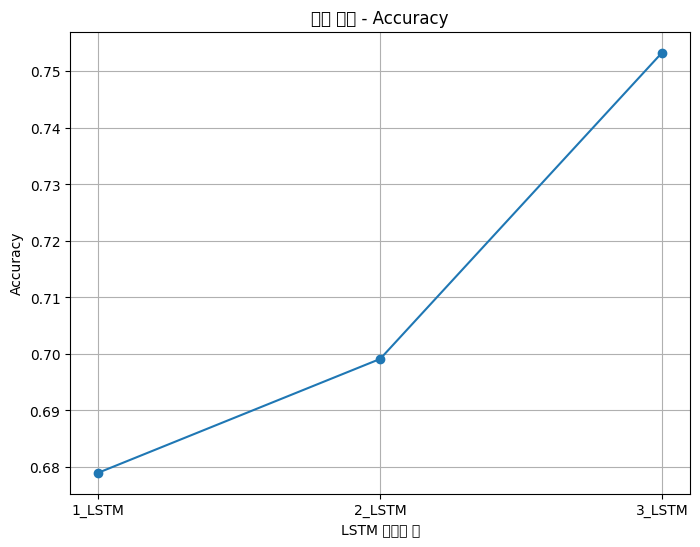

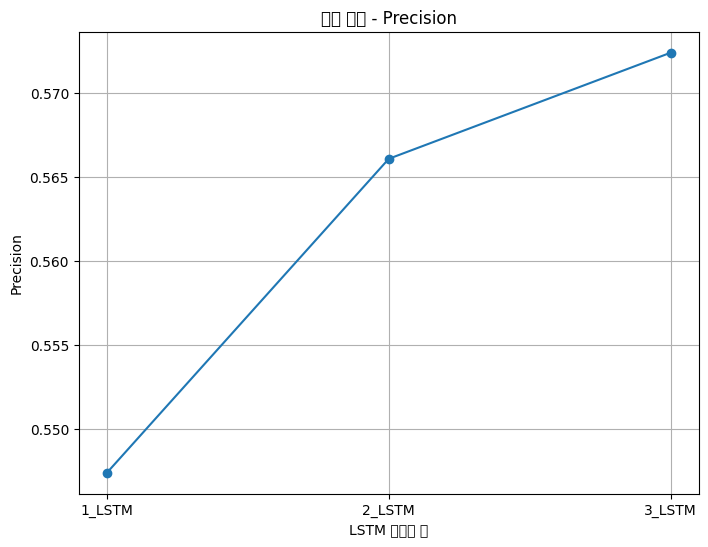

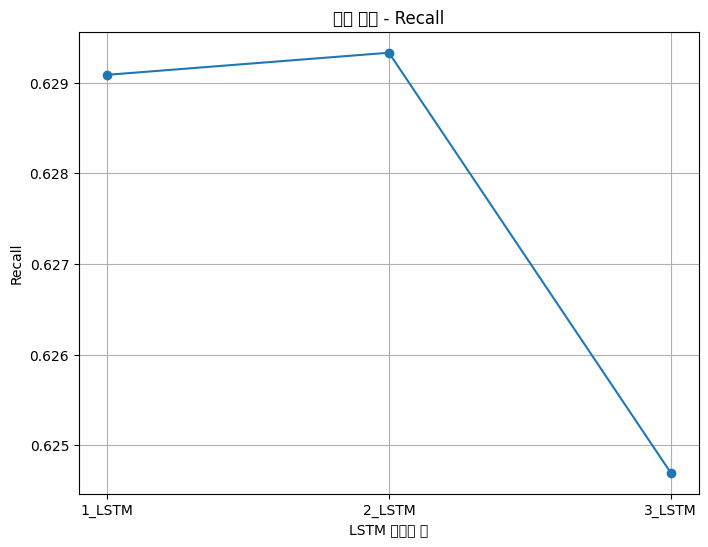

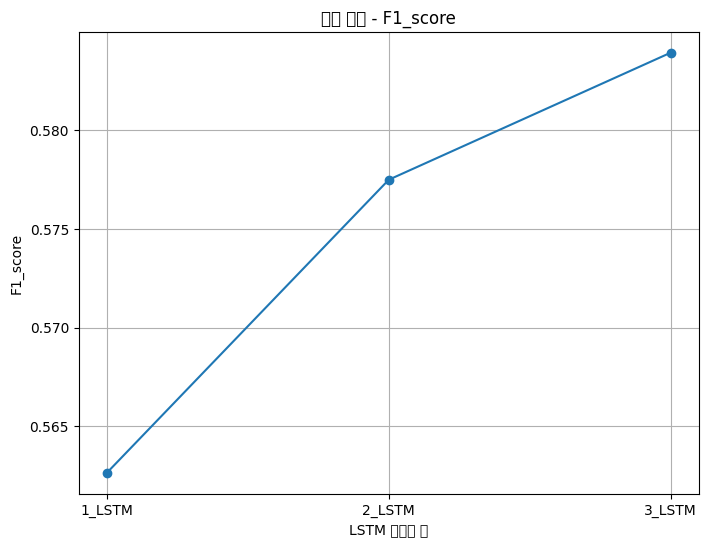

In [24]:
import matplotlib.pyplot as plt

# 모델의 성능 지표를 시각화하기 위한 함수 정의
def plot_model_performance(models):
    lstm_layers = ['1_LSTM', '2_LSTM', '3_LSTM']  # LSTM 레이어 수에 따른 키 설정
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']  # 시각화할 성능 지표

    for metric in metrics:
        plt.figure(figsize=(8, 6))
        values = [models[layer][metric] for layer in lstm_layers]
        plt.plot(lstm_layers, values, marker='o', linestyle='-', label=metric)
        plt.title(f'모델 성능 - {metric.capitalize()}')
        plt.xlabel('LSTM 레이어 수')
        plt.ylabel(metric.capitalize())
        plt.grid(True)
        plt.show()

# 모델의 성능 지표를 시각화
plot_model_performance(models)

In [25]:
# 모델을 HDF5 파일 형식으로 저장
model.save('/content/drive/MyDrive/논문주제/Final_project/xml_lstm.h5')

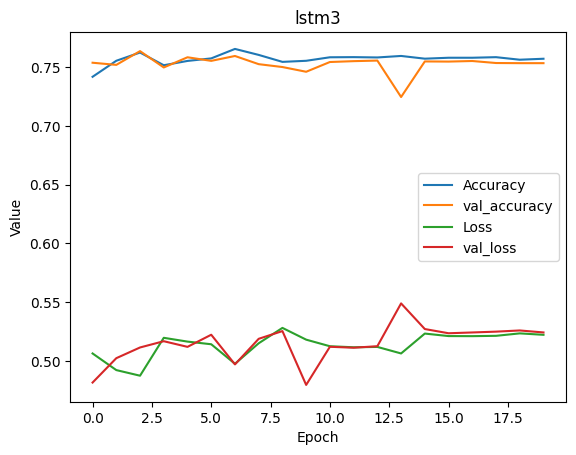

In [26]:
# 훈련 과정 시각화 (선택적)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('lstm3')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---

영상테스트

In [ ]:
!wget -q -O /content/DejaVuSans-Bold.ttf https://github.com/dejavu-fonts/dejavu-fonts/raw/master/ttf/

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow  # 코랩 환경에서 이미지 표시를 위한 모듈
import os

# 영상 파일 위치 지정
video_file = '/content/drive/MyDrive/논문주제/Final_project/Dataset/학교폭력 영상/F_176_1_0_0_0.mp4'

# YOLO 모델 정의 (학습 당시에는 v8x로 진행)
yolo_model = YOLO('yolov8n.pt')

# LSTM 모델 정의
lstm_model = load_model('/content/drive/MyDrive/논문주제/Final_project/my_model_lstm2.h5')

# 시퀀스 정의
sequences = []

# 시퀀스 길이
sequence_length = 8

# 동작 라벨 정의
actions = [
    "falling", "attack", "defense", "aggressive", "punch", "push",
    "grab_collar", "kicking", "elbow_strike", "shoving",
    "choking", "stomping", "crouching", "neutral"
]

# 위험한 동작 라벨 정의
dangerous_actions = [
    "falling", "attack", "aggressive", "punch", "grab_collar",
    "kicking", "elbow_strike", "shoving", "choking", "stomping"
]

# 이전에 그려진 박스의 좌표를 저장할 변수
prev_box = None

# 동영상 파일로부터 비디오 캡처 객체 생성
cap = cv2.VideoCapture(video_file)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)


def extract_keypoint(keypoints):
    # keypoints: [x, y, confidence, ...]
    return keypoints[:, :2].flatten().tolist()  # x, y 좌표만 사용

def find_closest_pairs(boxes, labels, keypoints):
    """
    주어진 조건에 따라 두 사람 간의 가장 적합한 바운딩 박스를 반환합니다.
    """
    min_distance = float('inf')
    closest_pair = None

    # 쓰러진 사람이 있는지 확인
    falling_indices = [i for i, label in enumerate(labels) if label == 'falling']
    if falling_indices:
        fallen_index = falling_indices[0]
        fallen_keypoints = keypoints[fallen_index]

        for i, kp in enumerate(keypoints):
            if i != fallen_index:
                distance = np.linalg.norm(np.array(fallen_keypoints[GetKeypoint.LEFT_HIP*2:GetKeypoint.LEFT_HIP*2+2]) -
                                          np.array(kp[GetKeypoint.LEFT_HIP*2:GetKeypoint.LEFT_HIP*2+2]))
                if distance < min_distance:
                    min_distance = distance
                    closest_pair = (fallen_index, i)

    # 웅크리고 있는 사람이 있는지 확인
    elif not closest_pair:
        crouching_indices = [i for i, label in enumerate(labels) if label == 'crouching']
        if crouching_indices:
            crouching_index = crouching_indices[0]
            crouching_keypoints = keypoints[crouching_index]

            for i, kp in enumerate(keypoints):
                if i != crouching_index:
                    distance = np.linalg.norm(np.array(crouching_keypoints[GetKeypoint.LEFT_HIP*2:GetKeypoint.LEFT_HIP*2+2]) -
                                              np.array(kp[GetKeypoint.LEFT_HIP*2:GetKeypoint.LEFT_HIP*2+2]))
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (crouching_index, i)

    # 두 사람이 있는 경우, 가장 가까운 두 사람을 선택
    if not closest_pair:
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                center_i = [(boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2]
                center_j = [(boxes[j][0] + boxes[j][2]) / 2, (boxes[j][1] + boxes[j][3]) / 2]
                distance = np.linalg.norm(np.array(center_i) - np.array(center_j))

                if distance < min_distance:
                    min_distance = distance
                    closest_pair = (i, j)

    return [boxes[closest_pair[0]], boxes[closest_pair[1]]]

def create_largest_box(box1, box2):
    """
    두 사람의 바운딩 박스를 감싸는 가장 큰 바운딩 박스를 생성합니다.
    """
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]

def calculate_font_center(box):
    """
    바운딩 박스의 중앙 위치를 계산하여 텍스트를 표시할 위치를 반환합니다.
    """
    center_x = (box[0] + box[2]) / 2
    center_y = (box[1] + box[3]) / 2
    return center_x, center_y

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    results = yolo_model(frame, save=False, classes=[0])

    if not results:
        continue

    # 키포인트가 있는지 확인하고 처리
    if results[0].keypoints is not None:
        results_keypoint = results[0].keypoints.xyn.cpu().numpy()
        labels = [classify_pose(extract_keypoint(kp)) for kp in results_keypoint]

        if len(results_keypoint) == 1:
            keypoint_list = extract_keypoint(results_keypoint[0])
            keypoint_list.extend([0] * 24)
        elif len(results_keypoint) >= 2:
            xy_list = results[0].boxes.xyxy.cpu().numpy().tolist()
            closest_boxes = find_closest_pairs(xy_list, labels, results_keypoint)
            keypoint_list1 = extract_keypoint(results_keypoint[0])
            keypoint_list2 = extract_keypoint(results_keypoint[1])
            keypoint_list = keypoint_list1 + keypoint_list2
        else:
            continue

        sequences.append(keypoint_list)

    if len(sequences) == sequence_length:
        sequences_array = np.array(sequences).reshape(1, sequence_length, -1)
        predictions = lstm_model.predict(sequences_array)

        action_index = np.argmax(predictions)
        action_name = actions[action_index]
        max_value = np.max(predictions)

        if action_name in dangerous_actions and max_value > 0.9:
            box_color = (0, 0, 255)
            last_dangerous_action_detected = action_name
        elif max_value > 0.5:
            box_color = (0, 128, 255)
            last_dangerous_action_detected = None
        else:
            box_color = (0, 255, 0)
            last_dangerous_action_detected = None

        largest_box = create_largest_box(*closest_boxes)

        prev_box = largest_box
        sequences.clear()

    if prev_box is not None:
        pil_im = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_im)

        draw.rectangle(((prev_box[0], prev_box[1]), (prev_box[2], prev_box[3])), outline=box_color, width=5)
        draw.text((prev_box[0], prev_box[1] - 40), action_name, font=font, fill=box_color)

        if last_dangerous_action_detected:
            danger_text = f"Danger! {last_dangerous_action_detected} detected!"
            draw.text((50, 100), danger_text, font=font, fill=(255, 0, 0))

        frame = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)

    cv2_imshow(frame)  # 코랩 환경에서는 cv2_imshow를 사용
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()